In [1]:
import pandas as pd
import numpy as np
import pyedflib
import os
import shutil
import glob
import datetime
from matplotlib import pyplot as plt

In [2]:
# Read raw PPG files

mdf = pd.read_csv(r'prof_data\resteaze\00000175-resteaze-sync.csv', sep=',')
mdf.head()

,Unnamed: 0,counter,unixTimes,accelerometerX,accelerometerY,accelerometerZ,capacitorsA,capacitorsB,capacitorsC,gyroscopeX,...,Leg Movement,Hypopnea,Arousal,RERA,Relative Desaturation,Obstructive Apnea,Central Apnea,Leg Movement (L),Leg Movement (R),shifted_unixTimes
0,187659,187686,1.643780e+12,-118.0,286.0,-4224.0,0.0,NaN,NaN,109.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12
1,187660,187691,1.643780e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.643780e+12
2,187661,187687,1.643780e+12,-122.0,281.0,-4214.0,0.0,NaN,NaN,77.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12
3,187662,187692,1.643780e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1.643780e+12
4,187663,187688,1.643780e+12,-133.0,279.0,-4212.0,0.0,NaN,NaN,82.0,...,0,0,0,0,0,0,0,0,0,1.643780e+12


In [3]:
df = mdf[['accelerometerX',	'accelerometerY', 'accelerometerZ', 'sleep_stage', 'sleep_state']].dropna()
# df['sleep_state'] = df['sleep_state'].mask(lambda col: col == -1, 6)


df = df[df.sleep_state != -1]

# Applying the condition
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)
df.head()

,accelerometerX,accelerometerY,accelerometerZ,sleep_stage,sleep_state
12098,53.0,-664.0,-4171.0,WK,0
12100,54.0,-668.0,-4176.0,WK,0
12102,44.0,-658.0,-4178.0,WK,0
12104,51.0,-660.0,-4172.0,WK,0
12105,50.0,-664.0,-4172.0,WK,0


In [4]:
# RMS of accelerometer data 
from numpy import mean, sqrt, square, arange

df['accelerometer'] = df[['accelerometerX',	'accelerometerY', 'accelerometerZ']].apply(lambda x: sqrt(square(x['accelerometerX']) + square(x['accelerometerY']) + square(x['accelerometerZ'])), axis=1)
df.head()

,accelerometerX,accelerometerY,accelerometerZ,sleep_stage,sleep_state,accelerometer
12098,53.0,-664.0,-4171.0,WK,0,4223.854401
12100,54.0,-668.0,-4176.0,WK,0,4229.434478
12102,44.0,-658.0,-4178.0,WK,0,4229.726232
12104,51.0,-660.0,-4172.0,WK,0,4224.190455
12105,50.0,-664.0,-4172.0,WK,0,4224.805321


In [5]:
df['sleep_stage'].value_counts(), df['sleep_state'].value_counts()

(N2     171303
 WK     138998
 N3     112415
 REM     62282
 N1      35695
 Name: sleep_stage, dtype: int64,
 1    381695
 0    138998
 Name: sleep_state, dtype: int64)

#### Apply band pass filter to the signal

In [30]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

# apply bandpass filter

fs = 25
lowcut = 0.35
highcut = 5.0

pro_acc = butter_bandpass_filter(df['accelerometer'], lowcut, highcut, fs, order=4)

In [31]:
from scipy import signal


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


# apply highpass filter

fs = 25
highcut = 5.0

high_acc = butter_highpass_filter(pro_acc, highcut, fs, order=4)

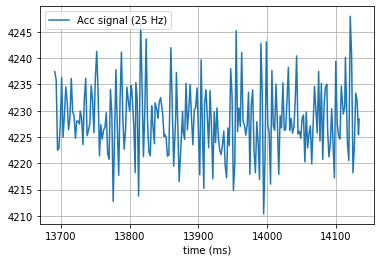

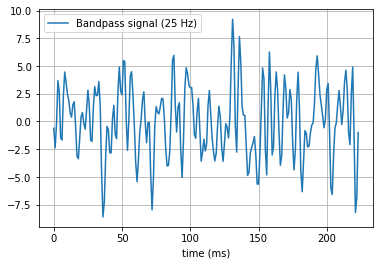

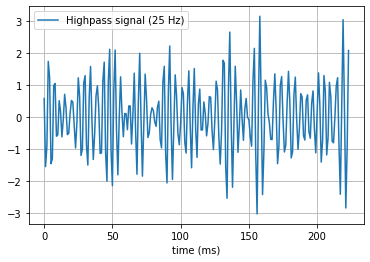

In [32]:
plt.plot(df['accelerometer'][800:1024], label='Acc signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

plt.plot(pro_acc[800:1024], label='Bandpass signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

plt.plot(high_acc[800:1024], label='Highpass signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [26]:
pro_acc.shape[0] % 750

193

In [28]:
acc_signals = pro_acc[:-(pro_acc.shape[0] % 750)].reshape(-1, 750)

In [29]:
acc_signals.shape

(694, 750)

In [73]:
timestamp = mdf['unixTimes'][0]

datetime.datetime.fromtimestamp(timestamp / 1000)

datetime.datetime(2022, 2, 2, 0, 33, 20)

### Visualize the predictions

In [1]:
# python predict.py --config_file config/resteaze.py --model_dir out_resteaze/train --output_dir out_resteaze/predict --log_file out_resteaze/predict.log --use-best

In [1]:
from numpy import load
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = load(r'out_resteaze\predict\pred_00011970-resteaze-sync.npz')

preds = pd.DataFrame(data=zip(data['y_true'],data['y_pred']),columns=['True','Preds'])

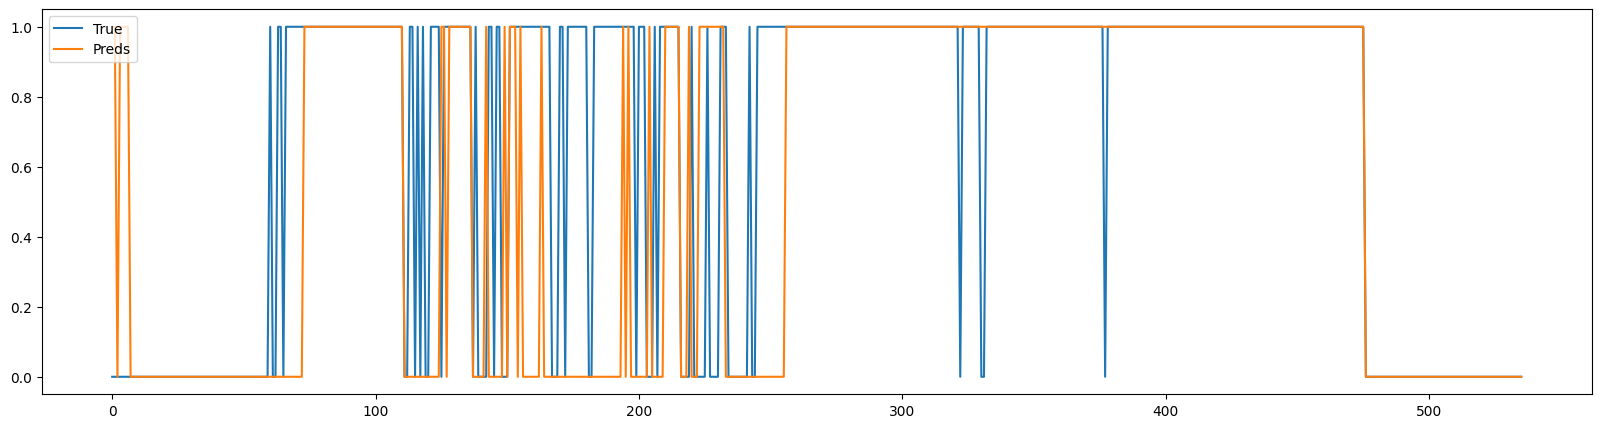

In [2]:
# figure size
plt.figure(figsize=(20,5))

plt.plot(preds['True'], label='True')
plt.plot(preds['Preds'], label='Preds')
plt.legend(loc='upper left')

plt.show();

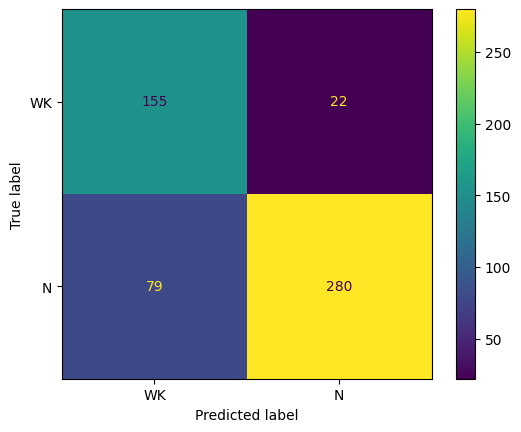

In [3]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(preds['True'], preds['Preds'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['WK', 'N'] )
cm_display.plot();



In [4]:
from sklearn.metrics import cohen_kappa_score

cohen_score = cohen_kappa_score(preds['True'].tolist(),preds['Preds'].tolist())
cohen_score

0.6061690673650517